In [1]:
import io
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tf.get_logger().setLevel("ERROR")

from tensorflow import keras
from keras import layers

import numpy as np
import pandas as pd

Training dataset: 5994
Test dataset: 5794


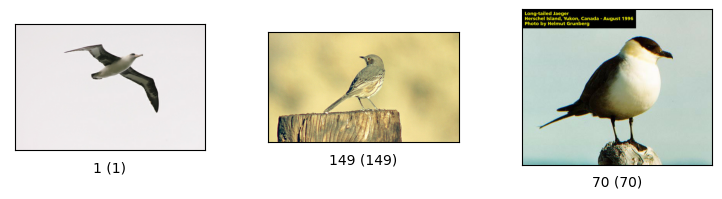

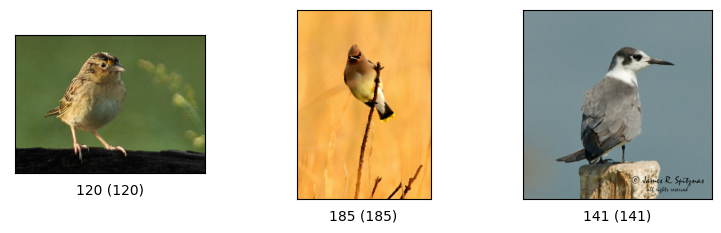

In [2]:
# Settings
batch_size = 16
img_width = 320
img_height = 320

# Fetch dataset
(train_ds_original, test_ds_original), ds_info = tfds.load(
    "caltech_birds2011", 
    split=["train", "test"], 
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

# Display dataset
print("Training dataset: {0}".format(len(train_ds_original)))
print("Test dataset: {0}".format(len(test_ds_original)))

fig = tfds.show_examples(train_ds_original.take(3), ds_info, image_key="image")
fig = tfds.show_examples(test_ds_original.take(3), ds_info, image_key="image")

In [3]:
# Data augmentation
augmentation = keras.Sequential([
    layers.RandomContrast(factor=0.1),
    layers.RandomFlip(mode="horizontal"),
    layers.RandomRotation(factor=0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    
    layers.Rescaling(scale=1./255),
])

num_classes = 3
filter_labels = lambda image, label: label == 0 or label == 1 or label == 2

indices = list(range(0, num_classes))
new_labels = tf.one_hot(indices, num_classes)

def modify_images(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    image = tf.image.resize_with_pad(
        image,
        img_height, img_width,
        method="bilinear",
        antialias=False,
    )
    
    image = augmentation(image)
    
#     return image, new_labels[label]
    return image, label

# Prepear dataset
train_ds = (
    train_ds_original
    .filter(filter_labels)
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_ds = (
    test_ds_original
    .filter(filter_labels)
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [4]:
# Setup model
model = keras.Sequential([
    # Input
    layers.InputLayer(input_shape=(img_height, img_width, 3)),

    # Block 1
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    # Block 3
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),
    
    # Block 4
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(),
    layers.Flatten(),

#     layers.Dense(256, activation="relu"),
#     layers.Dense(num_classes, activation="softmax"),

    layers.Dense(256, activation=None),
    layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)),
])

# Summarize model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 320, 320, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 320, 320, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 160, 160, 64)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 160, 160, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 128)     73856     
                                                      

In [5]:
# Prepear model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
    loss=tfa.losses.TripletSemiHardLoss(margin=0.2),
    metrics=["accuracy"],
)

# Train model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=32,
)

# Save model
model.save("output/model")

Epoch 1/32
6/6 [==============================] - 13s 1s/step - loss: 0.1299 - accuracy: 0.0000e+00 - val_loss: 0.1986 - val_accuracy: 0.0000e+00
Epoch 2/32
6/6 [==============================] - 1s 141ms/step - loss: 0.1002 - accuracy: 0.0222 - val_loss: 0.1985 - val_accuracy: 0.0000e+00
Epoch 3/32
6/6 [==============================] - 1s 142ms/step - loss: 0.0925 - accuracy: 0.0000e+00 - val_loss: 0.1981 - val_accuracy: 0.0000e+00
Epoch 4/32
6/6 [==============================] - 1s 142ms/step - loss: 0.0781 - accuracy: 0.0000e+00 - val_loss: 0.1982 - val_accuracy: 0.0000e+00
Epoch 5/32
6/6 [==============================] - 1s 142ms/step - loss: 0.0740 - accuracy: 0.0000e+00 - val_loss: 0.1983 - val_accuracy: 0.0000e+00
Epoch 6/32
6/6 [==============================] - 1s 142ms/step - loss: 0.0673 - accuracy: 0.0000e+00 - val_loss: 0.1985 - val_accuracy: 0.0000e+00
Epoch 7/32
6/6 [==============================] - 1s 143ms/step - loss: 0.0604 - accuracy: 0.0000e+00 - val_loss: 0.19

<AxesSubplot: >

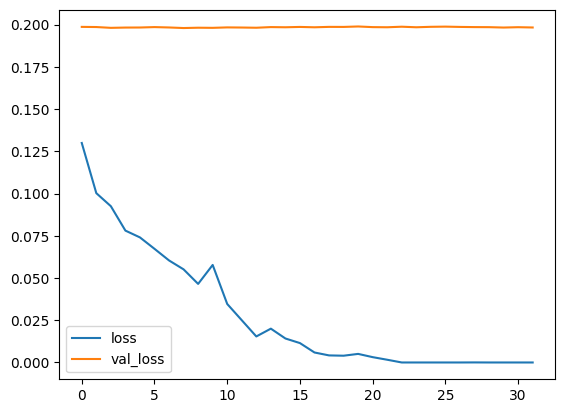

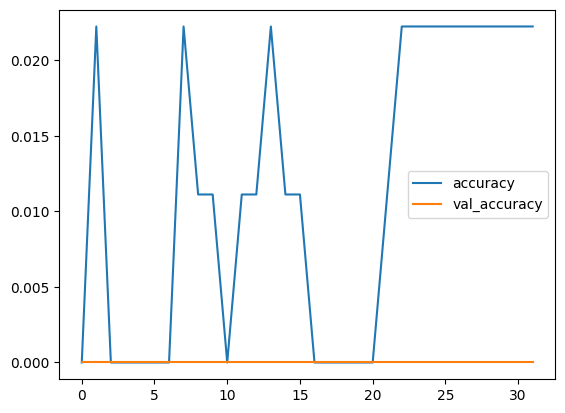

In [6]:
# Plot learning curves
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ["loss", "val_loss"]].plot()
history_frame.loc[:, ["accuracy", "val_accuracy"]].plot()

In [7]:
# Test network
results = model.predict(test_ds)

np.savetxt("output/vecs.tsv", results, delimiter="\t")

out_m = io.open("output/meta.tsv", "w", encoding="utf-8")
for img, labels in tfds.as_numpy(test_ds):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

6/6 [==============================] - 0s 35ms/step
